In [239]:
import pandas as pd
import numpy as np
from scipy.ndimage import uniform_filter1d

# scraping
import requests
from bs4 import BeautifulSoup
import re

# topic modeling
from gensim import corpora
from gensim.models import LdaModel
from gensim.parsing.preprocessing import preprocess_string
from gensim.parsing.preprocessing import remove_stopwords

# sentiment analysis
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
from collections import Counter


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\ivakr\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [29]:
# scrape transcript of the episode
url = 'https://transcripts.foreverdreaming.org/viewtopic.php?t=116998&view=print'

# get request
response = requests.get(url)
if response.status_code == 200:
    soup = BeautifulSoup(response.text, 'html.parser')
    lines = [re.split(r'\n|,', line) for line in soup.get_text().split('\n')]
    lines = [item for sublist in lines for item in sublist]
    text_df = pd.DataFrame(lines)
    # drop empty rows
    text_df = text_df[text_df[0] != '']
    text_df.to_csv('forks_lines.csv',index=False)

else:
    print(f"error: {response.status_code}")

# this is then cleaned up manually, and event start and end stamps are added manually based on the scenes.

Topic modeling

In [58]:
# read the clean csv back in 
text_clean = pd.read_csv('forks_lines_clean.csv').dropna()

# first, create a corpus of all the text in this episode
episode_corpus = text_clean['lines'].tolist()

# preprocess & create dictionary
processed_corpus = [preprocess_string(doc) for doc in episode_corpus]
dictionary = corpora.Dictionary(processed_corpus)

# bag of words corpus
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_corpus]

# lda model
lda_model = LdaModel(bow_corpus, num_topics=5, id2word=dictionary, passes=10)

topics = lda_model.print_topics()

topics


[(0,
  '0.089*"know" + 0.037*"ye" + 0.029*"woman" + 0.029*"fork" + 0.021*"jessica" + 0.015*"peopl" + 0.015*"right" + 0.015*"got" + 0.013*"carmi" + 0.013*"beep"'),
 (1,
  '0.073*"yeah" + 0.027*"love" + 0.026*"fak" + 0.017*"stop" + 0.017*"alright" + 0.013*"time" + 0.013*"start" + 0.012*"shit" + 0.011*"mean" + 0.011*"corner"'),
 (2,
  '0.093*"chef" + 0.063*"like" + 0.031*"gonna" + 0.026*"walk" + 0.021*"want" + 0.017*"let" + 0.013*"chang" + 0.013*"learn" + 0.011*"dude" + 0.009*"peopl"'),
 (3,
  '0.055*"fuck" + 0.025*"man" + 0.018*"go" + 0.018*"year" + 0.016*"wanna" + 0.016*"gui" + 0.014*"second" + 0.014*"hei" + 0.014*"dai" + 0.012*"drink"'),
 (4,
  '0.054*"richi" + 0.040*"thank" + 0.038*"garrett" + 0.025*"think" + 0.021*"smudg" + 0.017*"restaur" + 0.017*"need" + 0.017*"talk" + 0.015*"cousin" + 0.015*"manag"')]

Topics don't seem clear enough, switching to sentiment analysis scene by scene

In [240]:
sia = SentimentIntensityAnalyzer()
rolling_window = 10

# list of updated dfs
text_updated_list = []

for scene, scene_lines in text_clean.groupby('scene', as_index=False):
    # initialize list for polarity scores
    scene_polarity = []

    scene_line_list = scene_lines['lines'].tolist()
    # loop over rows for each scene
    # because the rows are not broken down by sentences but by the subtitles on a given screen,
    # we'll take a sliding window once we have all the scores
    
    for scene_line in scene_line_list:
        cur_senti_scores = sia.polarity_scores(scene_line)
        cur_compound = cur_senti_scores['compound']
        scene_polarity.append(cur_compound)

    # now apply rolling mean to this list
    scene_polarity_rolling = uniform_filter1d(scene_polarity, size=rolling_window)
    scene_lines['polarity'] = scene_polarity
    scene_lines['polarity_rolling'] = scene_polarity_rolling    
    text_updated_list.append(scene_lines)

text_df_updated = pd.concat(text_updated_list)

# save to csv
# for complex dataviz, we'll import this into R & work with it from there
text_df_updated.to_csv('forks_polarity_all.csv')

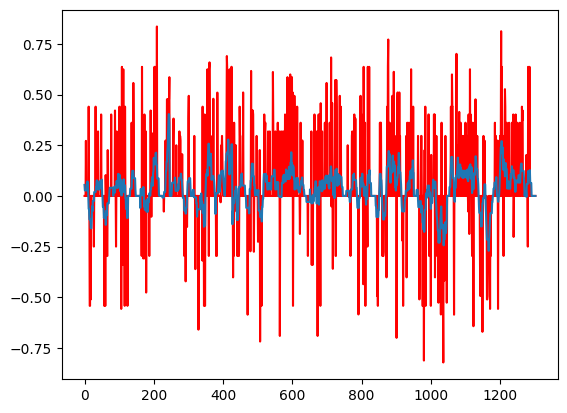

In [186]:
import matplotlib.pyplot as plt
plt.plot(text_df_updated['polarity'], color='red')
plt.plot(text_df_updated['polarity_rolling'])


In [168]:
# get the 'average' of the words per scene
# vector in the middle of all the vectors in the corpus
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

In [195]:
# APPROACH 1: Find 'average' word among word vectors
# define function to apply to each scene
def find_average_word(lines_df):
        
    # convert the column to a list of strings
    corpus_list = lines_df['lines'].astype(str).tolist()
        
    # tokenize and process the text
    tokenized_corpus = []
    stop_words = set(stopwords.words('english'))

    for text in corpus_list:
        tokens = word_tokenize(text.lower())  
        filtered_tokens = [word for word in tokens if word.isalnum() and word not in stop_words]
        tokenized_corpus.append(filtered_tokens)

    # word2vec model
    model = Word2Vec(tokenized_corpus, vector_size=100, window=5, min_count=1, workers=4)

    # calculate the average vector
    average_vector = np.mean([model.wv[word] for sentence in tokenized_corpus for word in sentence], axis=0)

    # find the word closest to the average vector
    closest_word = model.wv.similar_by_vector(average_vector, topn=1)[0][0]

    return closest_word
    

In [197]:
# apply to each scene & save to list
average_word_list = []

for scene, scene_lines in text_clean.groupby('scene', as_index=False):
    word_out = find_average_word(scene_lines)
    print(scene, word_out)


1.0 know
2.0 playing
3.0 forks
4.0 glass
5.0 respect
6.0 smudge
7.0 um
8.0 manager
9.0 stop
10.0 chef
11.0 chef
12.0 oh
13.0 know
14.0 fak
15.0 yeah


In [236]:
## APPROACH 2: find most common word in each scene
# turns out this is basically the same but anyway
from collections import Counter

def find_most_frequent_word(lines_df):
    # convert the column to a list of strings
    corpus_list = lines_df['lines'].astype(str).tolist()

    # tokenize and process the text
    tokenized_corpus = []
    stop_words = set(stopwords.words('english'))

    for text in corpus_list:
        tokens = word_tokenize(text.lower())
        filtered_tokens = [word for word in tokens if word.isalnum() and word not in stop_words]
        tokenized_corpus.extend(filtered_tokens) 

    # Count the occurrences of each word
    word_counts = Counter(tokenized_corpus)

    # Find the most common word
    most_common_word = word_counts.most_common(1)[0][0]

    return most_common_word


In [237]:
scene_lines = text_clean[text_clean['scene'] == 14]
word_out = find_most_frequent_word(scene_lines)
word_out

'fak'

In [238]:
# apply to each scene & save to list
average_word_list = []

for scene, scene_lines in text_clean.groupby('scene', as_index=False):
    word_out = find_most_frequent_word(scene_lines)
    print(scene, word_out)


1.0 know
2.0 alarm
3.0 forks
4.0 glass
5.0 think
6.0 smudge
7.0 um
8.0 manager
9.0 alarm
10.0 chef
11.0 chef
12.0 oh
13.0 know
14.0 fak
15.0 yeah
